# assignment goals

- What I'm interested in: NYC's adaptive reuse/gentrification efforts.
- What I'm looking for:   NYC's building construction year for different districts/zones.

I'm still pretty new to this so I'll just follow the class template and see where it goes!
- Load & explore data
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [59]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load data


In [2]:
# pluto = gpd.read_file("C:/Users/haole/Documents/CDP-MapSys/cdp-mapping-systems/Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [3]:
pluto_ogrio = ogr.read_dataframe("C:/Users/haole/Documents/CDP-MapSys/cdp-mapping-systems/Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

# data: ids and dtypes


In [4]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [5]:
pluto_ogrio.dtypes
# note to self: view them in a scrollable element.
# sometimes it's better to view the columns in this format, it's much more readable.

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

## there are a few columns that caught my interest:
- YearBuilt:    The year construction of the building was completed.
- YearAlter1:   If a building has only been altered once, YearAlter1 is the date that alteration began.
- YearAlter2:   If a building has been altered more than once, YearAlter2 is the year that the most recent alteration began.

For now, I'll keep it simple and only examine the YearBuilt column.

## exploring the data


In [6]:
pluto_ogrio.YearBuilt.value_counts().sort_index(ascending = False)
# use .sort_index to sort the column
# include ascending = False in the sort function to view the years in descending order.

YearBuilt
2023     1025
2022     1409
2021     1107
2020     1002
2019     1784
        ...  
1652        1
920         1
914         1
116         1
0       39771
Name: count, Length: 252, dtype: int64

## let's examine the data by borough

In [7]:
grouped = pluto_ogrio.groupby('Borough')['YearBuilt'].value_counts().sort_index(ascending=False)

print(grouped)

Borough  YearBuilt
SI       2023           222
         2022           344
         2021           323
         2020           246
         2019           502
                      ...  
BK       1766             1
         1747             1
         1725             1
         1652             1
         0            10310
Name: count, Length: 952, dtype: int64


## plotting time!


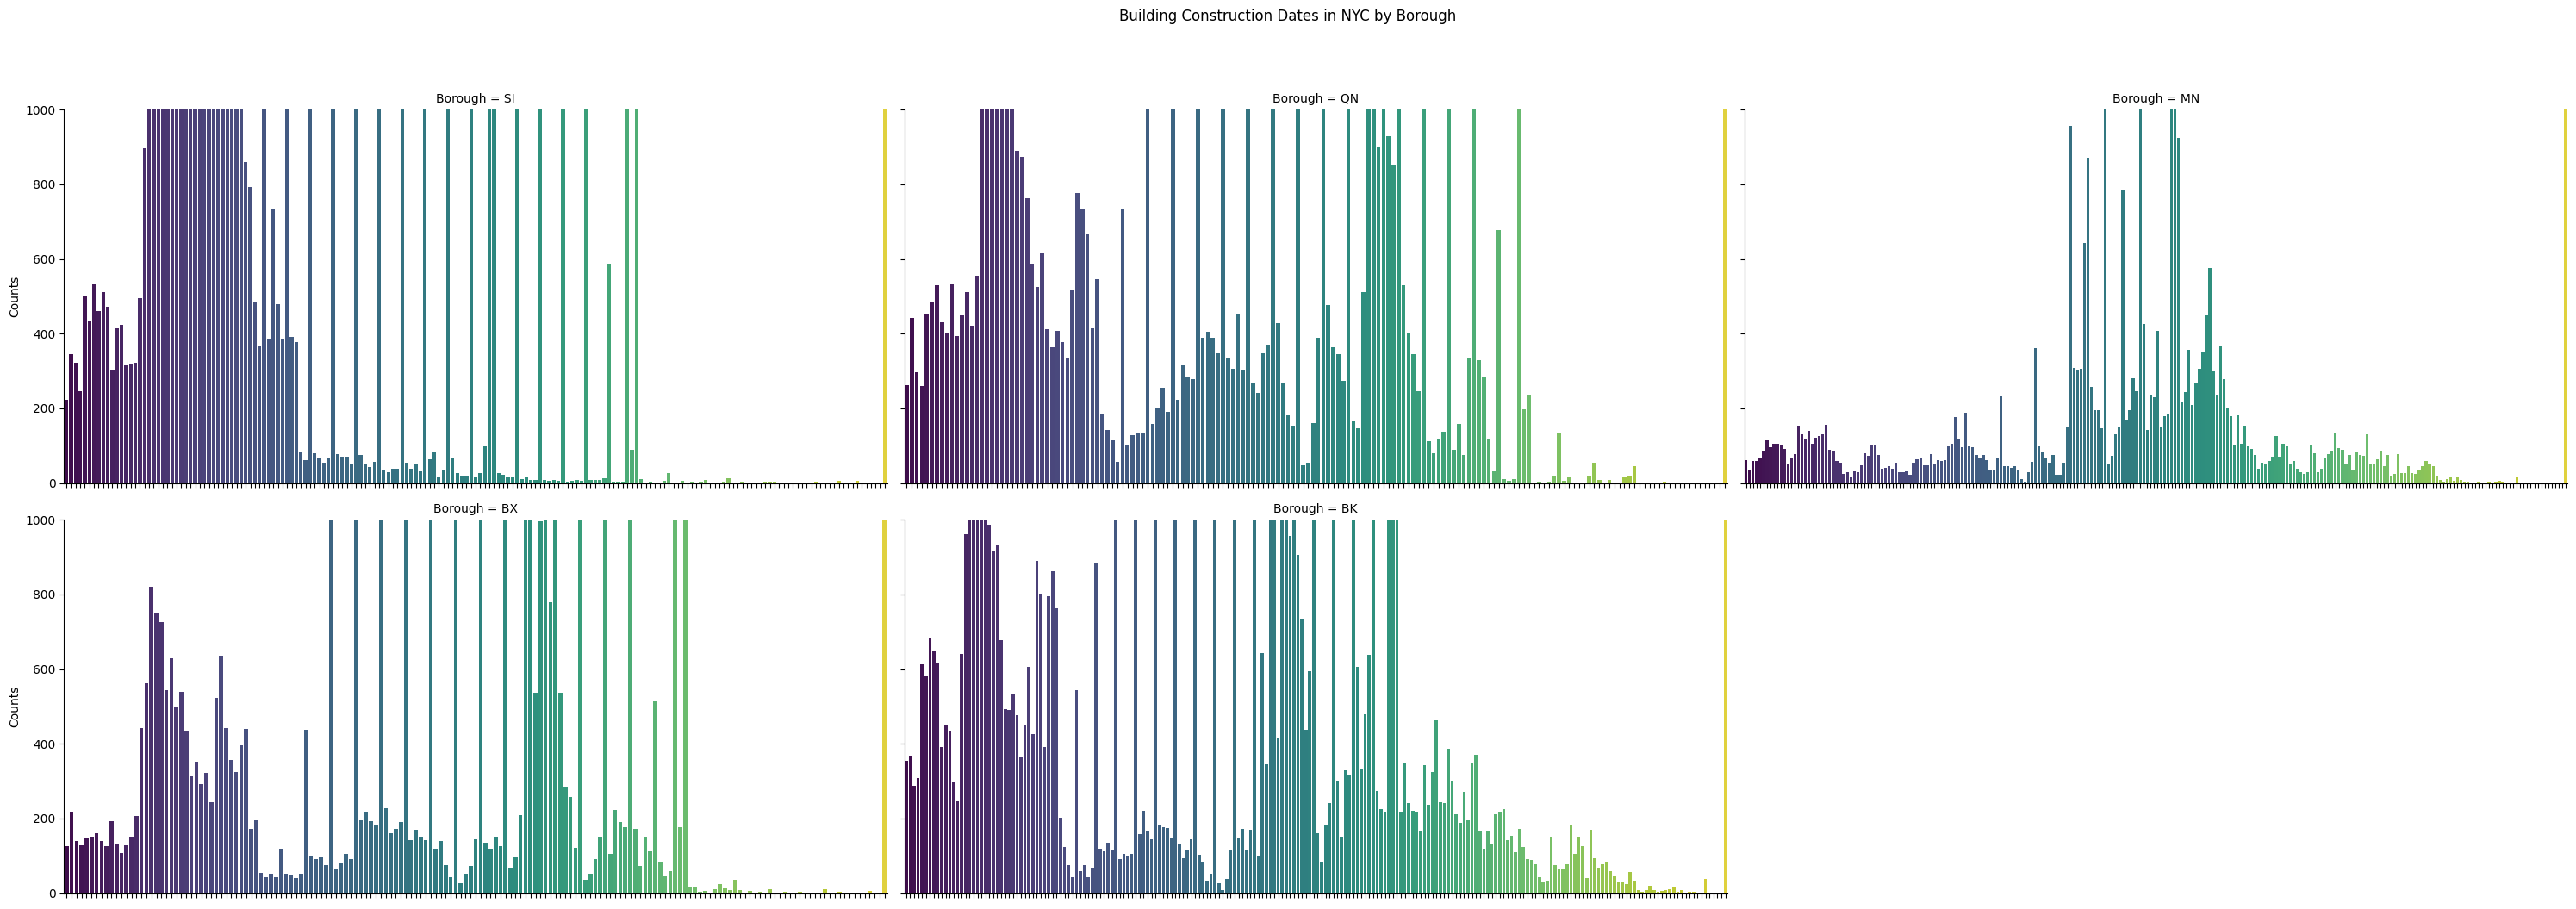

In [8]:
# setting up the dataframe and filtering out the "0" data
grouped_df = grouped.reset_index(name='Counts')
filtered_df = grouped_df[grouped_df['Counts'] > 0]

# Convert YearBuilt to categorical
filtered_df['YearBuilt'] = filtered_df['YearBuilt'].astype(str)

# Set up the FacetGrid for separate graphs for each borough
g = sns.FacetGrid(filtered_df, col="Borough", col_wrap=3, sharex=False, sharey=True, height=5, aspect=2)

# Create the bar plots
g.map_dataframe(sns.barplot, x='YearBuilt', y='Counts', hue='YearBuilt', palette='viridis', legend=False)

# Rotate x-axis labels, set y-axis limit, and remove x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_xlabel('')       # Remove x-axis label title
    ax.set_ylabel('Counts')
    ax.set_ylim(0, 1000)     # Adjust y-axis limit as needed

# Set a title for the entire plot
g.fig.suptitle('Building Construction Dates in NYC by Borough', y=1.05)

# Adjust the layout
plt.tight_layout()
plt.show()

## we can see that the plotted data shows a pattern in five-year intervals. Whys does this happen? Let's check the datadictionary:
In general, YEAR BUILT is accurate for the decade, but not necessarily for the 
specific year. Between 1910 and 1985, the majority of YEAR BUILT values are in 
years ending in 5 or 0.
So, now we're going to reorganize the data into years that end in 5 or 0.
For example, years ending between 0~4 will go into the "0" category, and years ending between 5~9 will go into the "5" category.

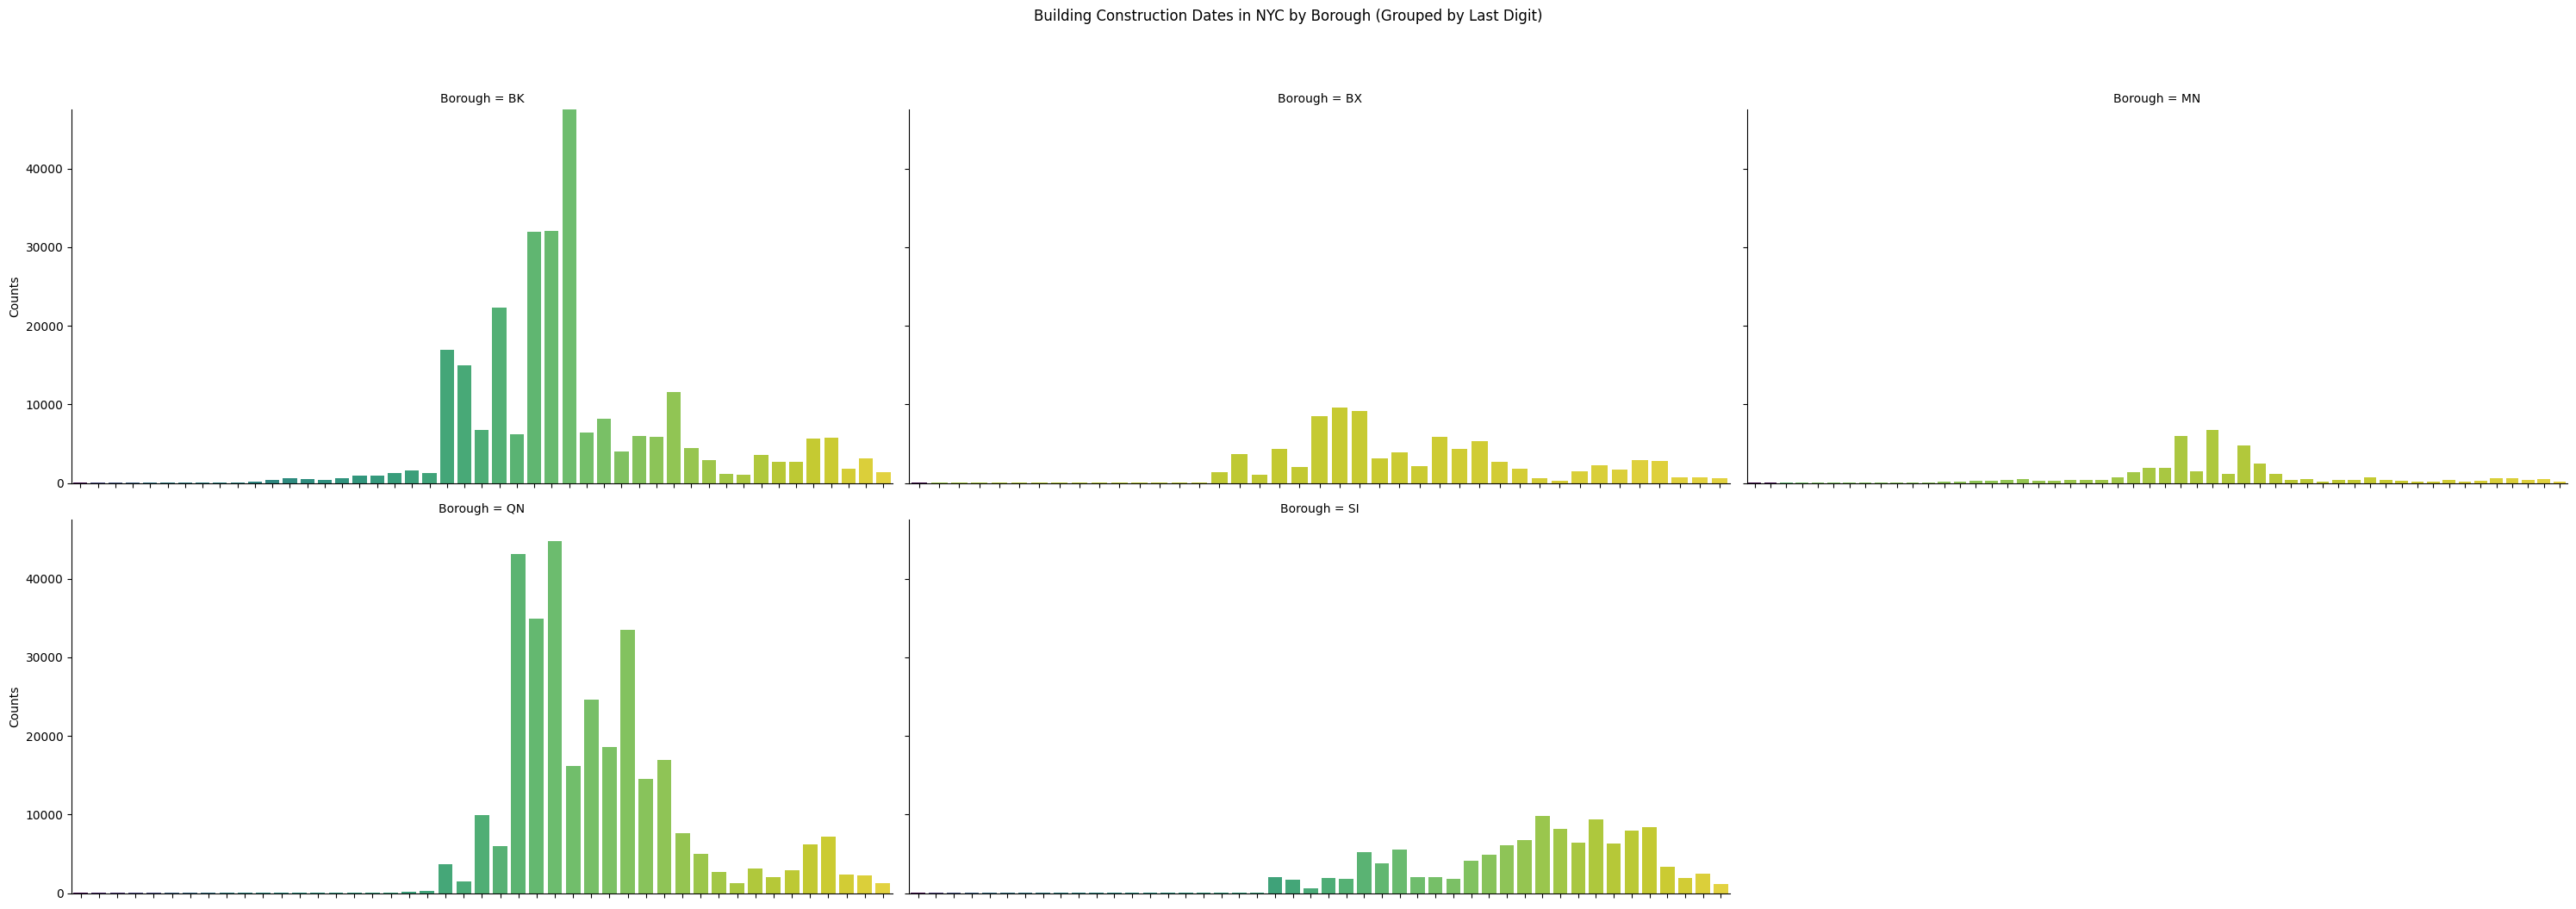

In [9]:
pluto_ogrio = pluto_ogrio[pluto_ogrio['YearBuilt'] != 0]

# Function to categorize YearBuilt
def categorize_year(year):
    last_digit = year % 10
    if last_digit <= 4:
        return year - last_digit
    else:
        return year + (5 - last_digit)

# Apply the function to create a new column 'YearBuilt_Categorized'
pluto_ogrio['YearBuilt_Categorized'] = pluto_ogrio['YearBuilt'].apply(categorize_year)

# Group by 'Borough' and 'YearBuilt_Categorized', then count occurrences
grouped = pluto_ogrio.groupby(['Borough', 'YearBuilt_Categorized']).size().reset_index(name='Counts')

# Set up the FacetGrid for separate graphs for each borough
g = sns.FacetGrid(grouped, col="Borough", col_wrap=3, sharex=False, sharey=True, height=5, aspect=2)

# Create the bar plots
g.map_dataframe(sns.barplot, x='YearBuilt_Categorized', y='Counts', hue='YearBuilt_Categorized', palette='viridis', legend=False)

# Rotate x-axis labels, set y-axis limit, and remove x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_xlabel('')       # Remove x-axis label title
    ax.set_ylabel('Counts')
    ax.set_ylim(0, grouped['Counts'].max())  # Adjust y-axis limit as needed

# Set a title for the entire plot
g.fig.suptitle('Building Construction Dates in NYC by Borough (Grouped by Last Digit)', y=1.05)

# Adjust the layout
plt.tight_layout()
plt.show()

Now we can see some interesting patterns going on. But first we need to transform the YearBuilt data to percentage to get a better comparison between boroughs.

C:\Users\haole\AppData\Local\Temp\ipykernel_34136\3002253161.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
C:\Users\haole\AppData\Local\Temp\ipykernel_34136\3002253161.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
C:\Users\haole\AppData\Local\Temp\ipykernel_34136\3002253161.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
C:\Users\haole\AppData\Local\Temp\ipykernel_34136\3002253161.py:31: UserWarning: set_ticklabels() should only be used with a fixed numbe

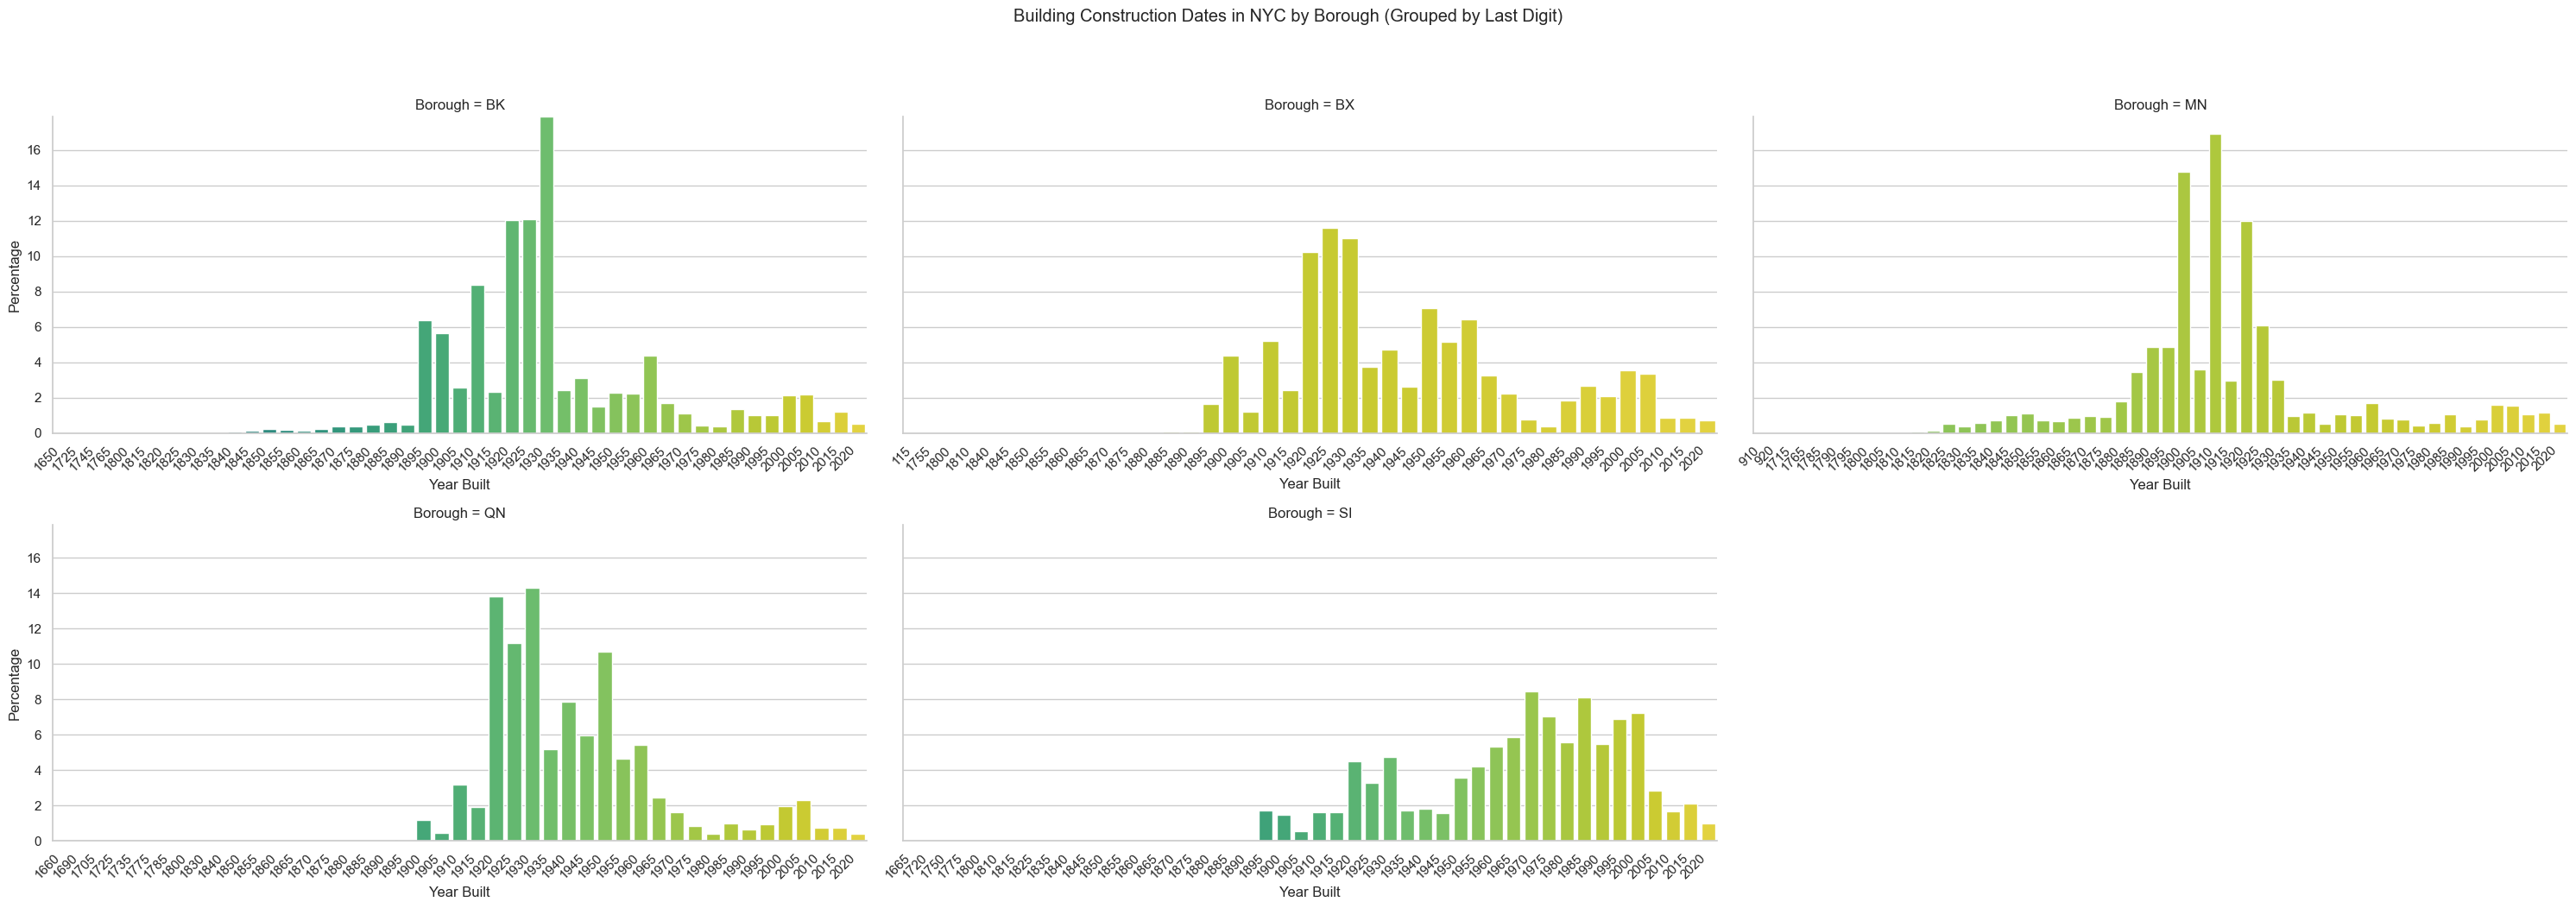

In [48]:
pluto_ogrio = pluto_ogrio[pluto_ogrio['YearBuilt'] != 0]

# Function to categorize YearBuilt
def categorize_year(year):
    last_digit = year % 10
    if last_digit <= 4:
        return year - last_digit
    else:
        return year + (5 - last_digit)

# Apply the function to create a new column 'YearBuilt_Categorized'
pluto_ogrio['YearBuilt_Categorized'] = pluto_ogrio['YearBuilt'].apply(categorize_year)

# Group by 'Borough' and 'YearBuilt_Categorized', then count occurrences
grouped = pluto_ogrio.groupby(['Borough', 'YearBuilt_Categorized']).size().reset_index(name='Counts')

# Calculate the total number of buildings for each borough
total_counts = grouped.groupby('Borough')['Counts'].transform('sum')

# Calculate the percentage
grouped['Percentage'] = (grouped['Counts'] / total_counts) * 100

# Set up the FacetGrid for separate graphs for each borough
g = sns.FacetGrid(grouped, col="Borough", col_wrap=3, sharex=False, sharey=True, height=5, aspect=2)

# Create the bar plots
g.map_dataframe(sns.barplot, x='YearBuilt_Categorized', y='Percentage', hue='YearBuilt_Categorized', palette='viridis', legend=False)

# Rotate x-axis labels, set y-axis limit, and remove x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
    ax.set_xlabel('Year Built')  # Set x-axis label title
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, grouped['Percentage'].max())  # Adjust y-axis limit as needed

# Set a title for the entire plot
g.fig.suptitle('Building Construction Dates in NYC by Borough (Grouped by Last Digit)', y=1.05)

# Adjust the layout
plt.tight_layout()
plt.show()


Verrrrrry interesting. But I don't think bar charts are the best way to compare these kinds of data. Can we turn them into area charts and compare them in the same graph?

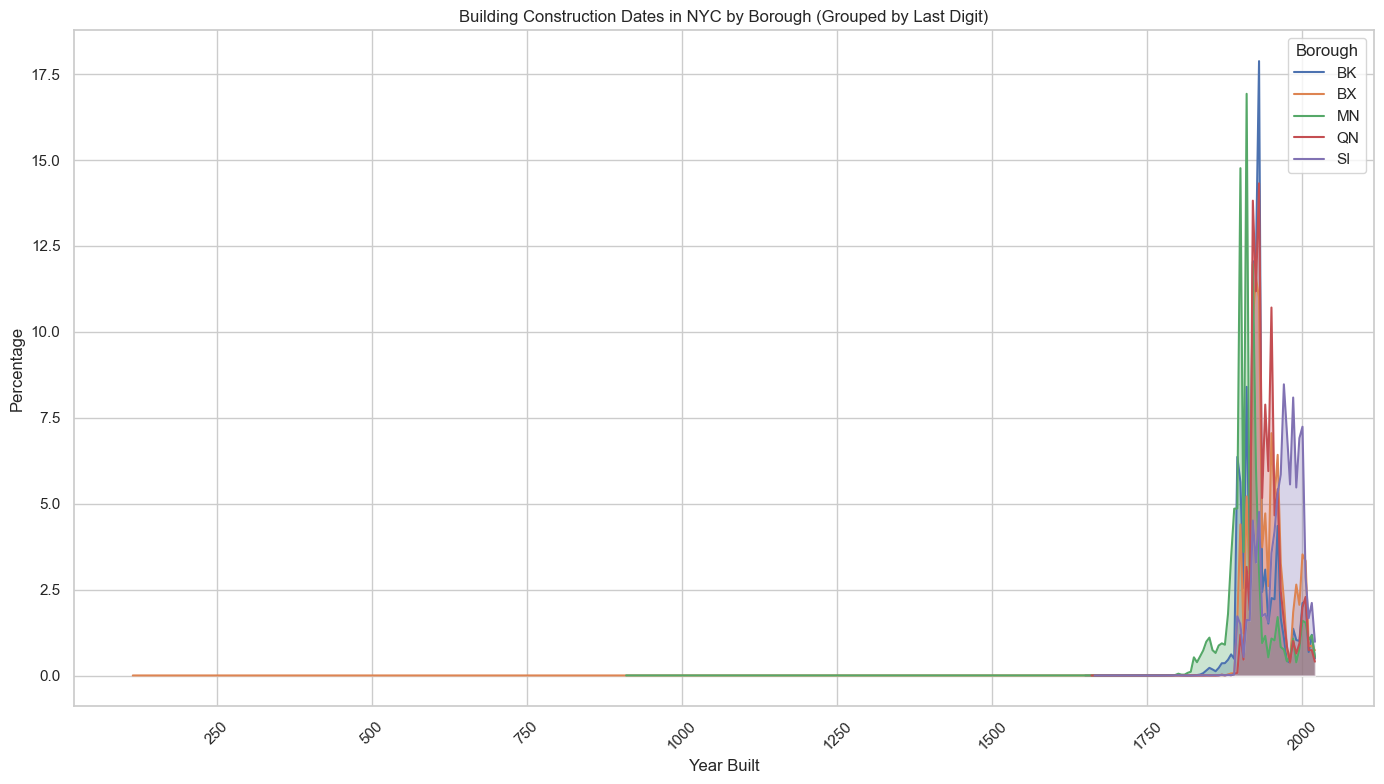

In [49]:
pluto_ogrio = pluto_ogrio[pluto_ogrio['YearBuilt'] != 0]

# Function to categorize YearBuilt
def categorize_year(year):
    last_digit = year % 10
    if last_digit <= 4:
        return year - last_digit
    else:
        return year + (5 - last_digit)

# Apply the function to create a new column 'YearBuilt_Categorized'
pluto_ogrio['YearBuilt_Categorized'] = pluto_ogrio['YearBuilt'].apply(categorize_year)

# Group by 'Borough' and 'YearBuilt_Categorized', then count occurrences
grouped = pluto_ogrio.groupby(['Borough', 'YearBuilt_Categorized']).size().reset_index(name='Counts')

# Calculate the total number of buildings for each borough
total_counts = grouped.groupby('Borough')['Counts'].transform('sum')

# Calculate the percentage
grouped['Percentage'] = (grouped['Counts'] / total_counts) * 100

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot the area charts for each borough
for borough in grouped['Borough'].unique():
    borough_data = grouped[grouped['Borough'] == borough]
    sns.lineplot(data=borough_data, x='YearBuilt_Categorized', y='Percentage', label=borough)
    plt.fill_between(borough_data['YearBuilt_Categorized'], borough_data['Percentage'], alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.xlabel('Year Built')
plt.ylabel('Percentage')
plt.title('Building Construction Dates in NYC by Borough (Grouped by Last Digit)')
plt.legend(title='Borough')

# Adjust the layout
plt.tight_layout()
plt.show()


Let's try and truncate the data before 1890.

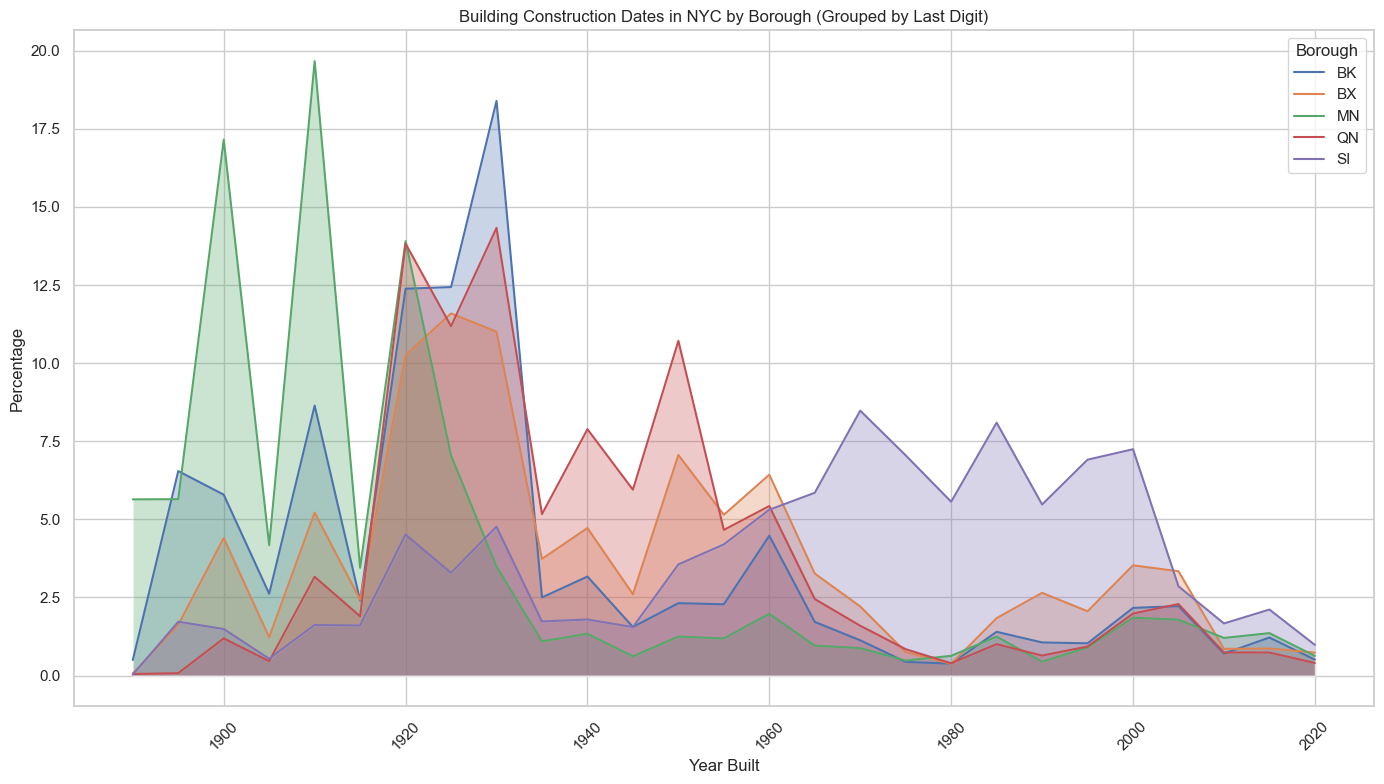

In [54]:
# Filter out rows where YearBuilt is 0 or before 1800
pluto_ogrio = pluto_ogrio[(pluto_ogrio['YearBuilt'] != 0) & (pluto_ogrio['YearBuilt'] >= 1800)]

# Function to categorize YearBuilt
def categorize_year(year):
    last_digit = year % 10
    if last_digit <= 4:
        return year - last_digit
    else:
        return year + (5 - last_digit)

# Apply the function to create a new column 'YearBuilt_Categorized'
pluto_ogrio['YearBuilt_Categorized'] = pluto_ogrio['YearBuilt'].apply(categorize_year)

# Group by 'Borough' and 'YearBuilt_Categorized', then count occurrences
grouped = pluto_ogrio.groupby(['Borough', 'YearBuilt_Categorized']).size().reset_index(name='Counts')

# Calculate the total number of buildings for each borough
total_counts = grouped.groupby('Borough')['Counts'].transform('sum')

# Calculate the percentage
grouped['Percentage'] = (grouped['Counts'] / total_counts) * 100

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot the area charts for each borough
for borough in grouped['Borough'].unique():
    borough_data = grouped[grouped['Borough'] == borough]
    sns.lineplot(data=borough_data, x='YearBuilt_Categorized', y='Percentage', label=borough)
    plt.fill_between(borough_data['YearBuilt_Categorized'], borough_data['Percentage'], alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.xlabel('Year Built')
plt.ylabel('Percentage')
plt.title('Building Construction Dates in NYC by Borough (Grouped by Last Digit)')
plt.legend(title='Borough')

# Adjust the layout
plt.tight_layout()
plt.show()


Because the data isn't so accurate (e.g., there probably won't be such apparent spikes in the real world,) lets turn this graph into a trendline graph.

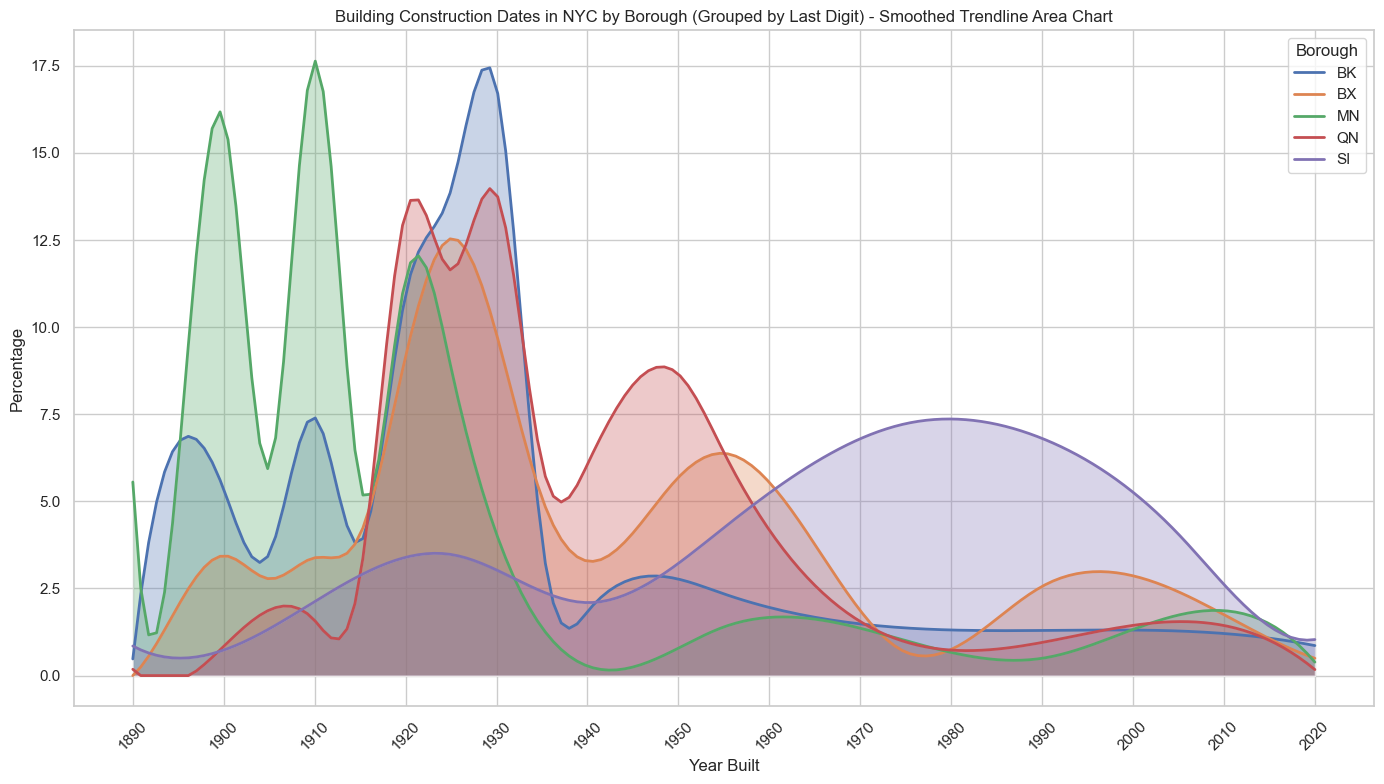

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

# Filter out rows where YearBuilt is 0 or before 1800
pluto_ogrio = pluto_ogrio[(pluto_ogrio['YearBuilt'] != 0) & (pluto_ogrio['YearBuilt'] >= 1800)]

# Function to categorize YearBuilt
def categorize_year(year):
    last_digit = year % 10
    if last_digit <= 4:
        return year - last_digit
    else:
        return year + (5 - last_digit)

# Apply the function to create a new column 'YearBuilt_Categorized'
pluto_ogrio['YearBuilt_Categorized'] = pluto_ogrio['YearBuilt'].apply(categorize_year)

# Group by 'Borough' and 'YearBuilt_Categorized', then count occurrences
grouped = pluto_ogrio.groupby(['Borough', 'YearBuilt_Categorized']).size().reset_index(name='Counts')

# Calculate the total number of buildings for each borough
total_counts = grouped.groupby('Borough')['Counts'].transform('sum')

# Calculate the percentage
grouped['Percentage'] = (grouped['Counts'] / total_counts) * 100

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot the area charts for each borough
for borough in grouped['Borough'].unique():
    borough_data = grouped[grouped['Borough'] == borough]
    x = borough_data['YearBuilt_Categorized']
    y = borough_data['Percentage']
    
    # Use scipy's interpolate to smooth the data
    spl = interpolate.UnivariateSpline(x, y)
    x_smooth = np.linspace(x.min(), x.max(), 150)
    y_smooth = spl(x_smooth)
    
    # Ensure y_smooth values are non-negative
    y_smooth = np.maximum(y_smooth, 0)

    # Plot smoothed trendline with fill_between
    plt.plot(x_smooth, y_smooth, label=borough, linewidth=2)
    plt.fill_between(x_smooth, y_smooth, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.xlabel('Year Built')
plt.ylabel('Percentage')
plt.title('Building Construction Dates in NYC by Borough (Grouped by Last Digit) - Smoothed Trendline Area Chart')

# Double the x-axis grid density
plt.locator_params(axis='x', nbins=20)

# Adjust the legend
plt.legend(title='Borough')

# Adjust the layout
plt.tight_layout()
plt.show()

## some interesting trends
- a lot of NYC buildings are built during the 1920s to the 1930s.
- Staten Island wasn't developed much until the 1950s.
- most of Manhatten's buildings were built before the 1940s.

# now, let's check out the same graph, but with YearAlter1 instead of YearBuilt.

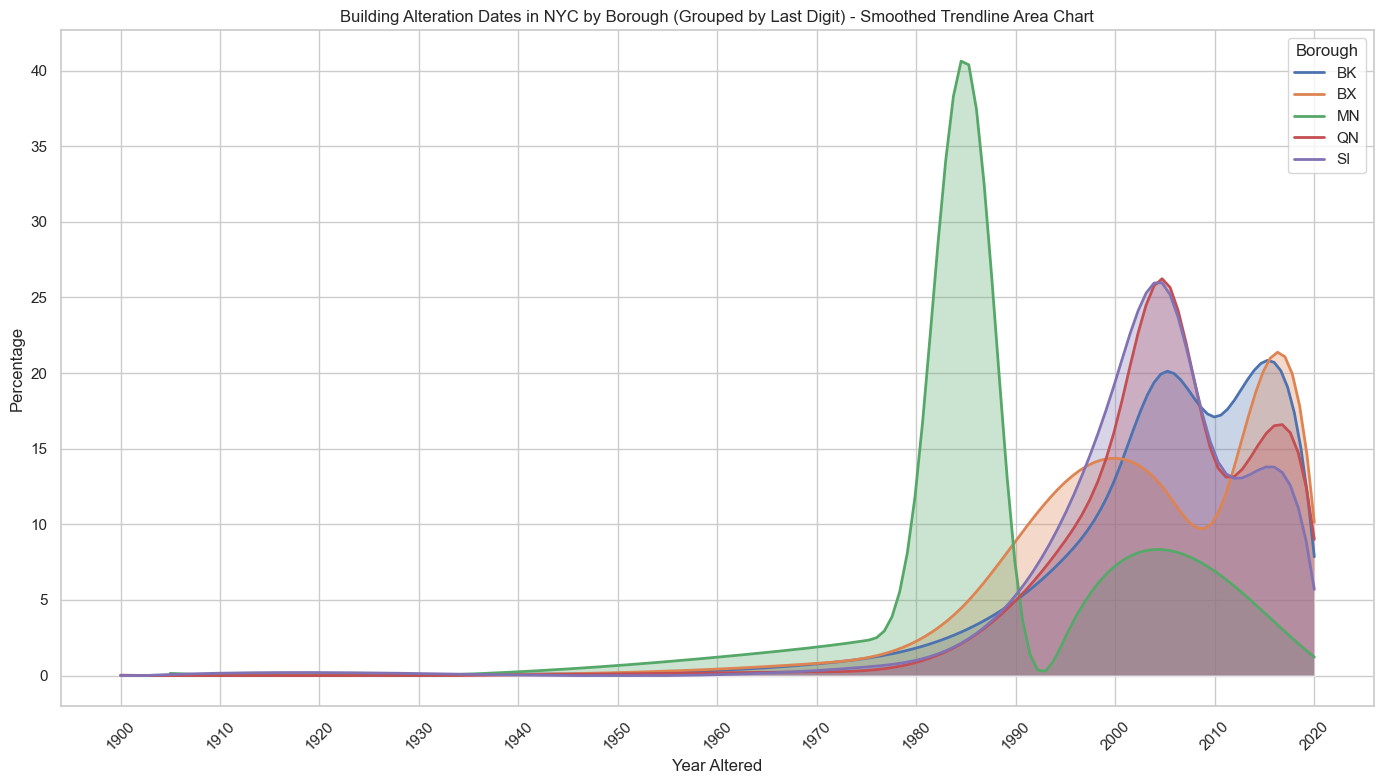

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

# Filter out rows where YearBuilt is 0 or before 1800
pluto_ogrio = pluto_ogrio[(pluto_ogrio['YearAlter1'] != 0) & (pluto_ogrio['YearAlter1'] >= 1800)& (pluto_ogrio['YearAlter1'] <= 2024)]

# Function to categorize YearBuilt
def categorize_year(year):
    last_digit = year % 10
    if last_digit <= 4:
        return year - last_digit
    else:
        return year + (5 - last_digit)

# Apply the function to create a new column 'YearAlter_Categorized'
pluto_ogrio['YearAlter_Categorized'] = pluto_ogrio['YearAlter1'].apply(categorize_year)

# Group by 'Borough' and 'YearAlter_Categorized', then count occurrences
grouped = pluto_ogrio.groupby(['Borough', 'YearAlter_Categorized']).size().reset_index(name='Counts')

# Calculate the total number of buildings for each borough
total_counts = grouped.groupby('Borough')['Counts'].transform('sum')

# Calculate the percentage
grouped['Percentage'] = (grouped['Counts'] / total_counts) * 100

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot the area charts for each borough
for borough in grouped['Borough'].unique():
    borough_data = grouped[grouped['Borough'] == borough]
    x = borough_data['YearAlter_Categorized']
    y = borough_data['Percentage']
    
    # Use scipy's interpolate to smooth the data
    spl = interpolate.UnivariateSpline(x, y)
    x_smooth = np.linspace(x.min(), x.max(), 150)
    y_smooth = spl(x_smooth)
    
    # Ensure y_smooth values are non-negative
    y_smooth = np.maximum(y_smooth, 0)

    # Plot smoothed trendline with fill_between
    plt.plot(x_smooth, y_smooth, label=borough, linewidth=2)
    plt.fill_between(x_smooth, y_smooth, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.xlabel('Year Altered')
plt.ylabel('Percentage')
plt.title('Building Alteration Dates in NYC by Borough (Grouped by Last Digit) - Smoothed Trendline Area Chart')

# Double the x-axis grid density
plt.locator_params(axis='x', nbins=20)

# Adjust the legend
plt.legend(title='Borough')

# Adjust the layout
plt.tight_layout()
plt.show()

# key takeaways
- the 1980s was really crazy for Manhatten. What spurred this uptick of alterations?
- what happened to Manhatten around 1993 and to other boroughs around 2010?

## let's compile all the discoveries (and some answers via wiki & GPT):
- a lot of NYC buildings are built during the 1920s to the 1930s. (the economic boom before the Great Depression; because of the inherent timespan in construction cycles, the timing is a bit delayed too.)
- Staten Island wasn't developed much until the 1950s.(the G.I. Bill propelled SI into a suburban haven.)
- most of Manhatten's buildings were built before the 1940s. (limited land area and early developments)
- the 1980s was really crazy for Manhatten. What spurred this uptick of alterations? (the rise of Wall Street and the real estate development.)
- what happened to Manhatten around 1993 and to other boroughts around 2010? (gentrification and gentrification.)

# let's view the data from a different angle

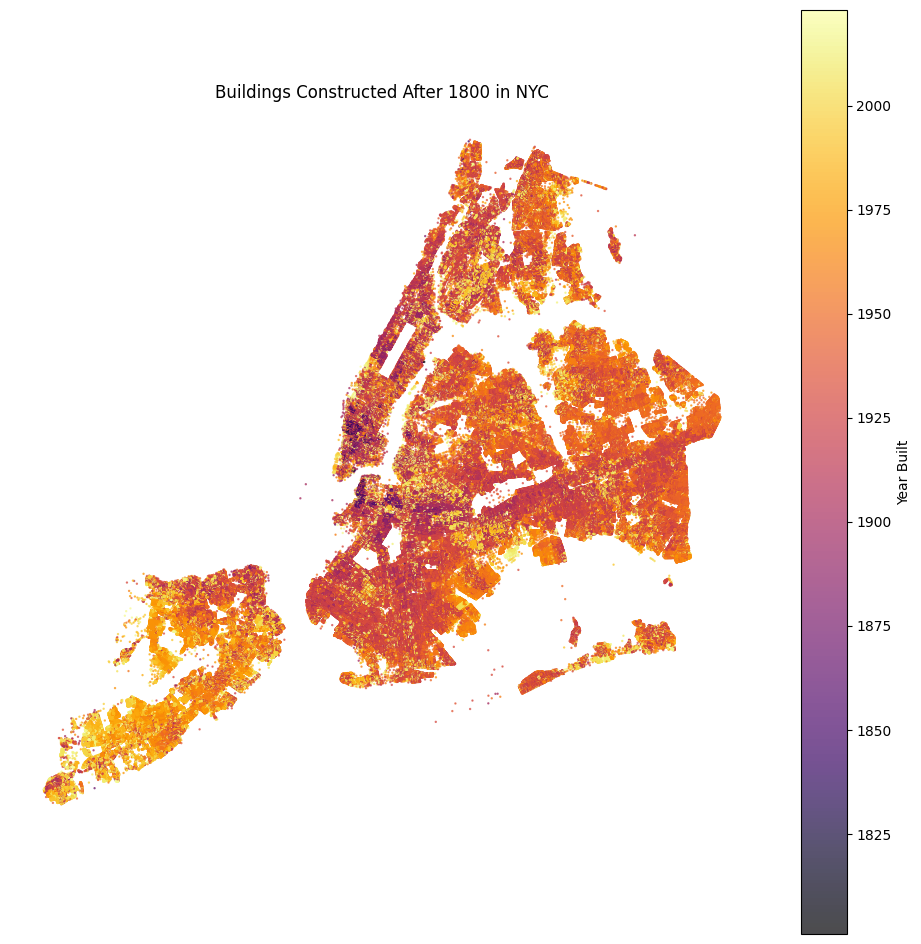

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your PLUTO data
pluto = gpd.read_file("../Assignment-1/Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

# Convert "YearBuilt" to numeric if necessary
pluto['YearBuilt'] = pd.to_numeric(pluto['YearBuilt'], errors='coerce')

# Filter buildings constructed after 1800
pluto = pluto[pluto['YearBuilt'] > 1800]

# Plotting the map with Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the figure size as needed

# Scatter plot of buildings colored by construction year
sc = ax.scatter(pluto['geometry'].centroid.x, pluto['geometry'].centroid.y, 
                c=pluto['YearBuilt'], cmap='inferno', s=0.5, alpha=0.7)  # Adjust s for smaller dots

# Remove axes
ax.axis('off')

# Add colorbar
cbar = plt.colorbar(sc, orientation='vertical', label='Year Built')

# Add title
plt.title('Buildings Constructed After 1800 in NYC')

# Set aspect ratio to 'equal' to avoid stretching
ax.set_aspect('equal')

plt.show()


Notice how there are group differences on the map? Some are generally older (darker) or newer (lighter), and some have drastic differences within the same area (dark and light). With some other data in the PLUTO dataset, maybe we can compare them and draw some broad conclusions.
Because I'm interested in adaptive reuse and the complications of gentrification, maybe the next step would be combining population income between these areas of interest across different timespans.

## your turn: can you make the above show in 3d?

In [7]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

In [66]:
df = pluto_ogrio_wgs[pluto_ogrio_wgs.YearBuilt>1900][["YearBuilt", "geometry"]]
df['YearBuilt_shifted'] = df['YearBuilt'] - 1900

normalizer = LogNorm(1, df.YearBuilt_shifted.max(), clip=True)
normalized_floors = normalizer(df.YearBuilt_shifted)

layer = PolygonLayer.from_geopandas(
    df[["YearBuilt_shifted", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    extruded = True,
    get_elevation = df["YearBuilt_shifted"]
)
m = Map(layer)
m


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x00000172863527A0>
[
…